<a href="https://colab.research.google.com/github/kamo1010/injury-big-data/blob/main/Random_forest_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅데이터 분석 코드


본 연구는 의료 진료를 위한 후송 데이터를 연구하려고자 합니다.
Random forest 알골즘을 바탕으로 환자의 생존과 사망을 예측하기 위해 후송 데이터를 활용해서 원인들의 중요성을 측정하기로 합니다.

## 데이터 후처리

csv 파일을 읽어서 데이터를 뽑기로 합니다.
Pandas framework을 써서 파일에 든 데이터를 Dataframe 현태로 불러옵니다.
우선 그러기 전에 필요한 코드 라이브러리를 불러옵니다.

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas.tseries.offsets import Minute
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split

Pandas를 써봅니다.

데이터를 불러와서 내용부터 확인해봅시다.

In [31]:
bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

,연번,년도,월,일,날,주야간,기상조건,도시,지역,사무실,...,증상,환자유형,접수시간/이륙시간,환자 인수지역,도착시간/이륙시간,환자 후송지,후송지 도착 시간,복귀 이륙/복귀도착,출동~병원,후송결과
0,1,2021,7,27,목,주,go,대전,유성,문지로,...,두통,외상,1333/1454,A,1500/1503,대전병원,1537,1613/1720,133분,사망
1,2,2021,7,26,수,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
2,3,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
3,4,2021,7,25,화,주,go,인재,내일,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망
4,5,2021,7,21,금,주,go,계룡,엄사,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망


칼럼 21개 중 후처리로 몇가지 새로운 데이터로 전환할 수 있습니다.

0. 인코딩 문제가 없도록 각 행 명을 영문으로 바꿉니다: **``date``**, **``season``**, **``day or night``**, **``city``**, **``district``**, **``location``**, **``position``**, **``wound``**, **``patient type``**, **``patient acceptance area``**, **``patient transfer area``**,
1. **``연번``**은 불필요한 ID 를 불러오며, 제거할 수 있겠습니다.
2. **``년도``**, **``월``**, **``일``** 행들을 **``날짜``** 데이터로 바꿀 수 있습니다. 추가로 월에거 **``계절``** 정보까지 수집할 수 있습니다.
3. **``주야간``** (**``day or night``**) 데이터는 유지시킬 수 있겠습니다.
4. **``도시``**, **``지역``**, **``사무실``**, **``환자 인수지역``**, 그리고 **``환자 후송지``**는 지역과 후송 정보를 가지고 있으며 그대로 유지할 필요가 있다.
5. **``급``**, **``증상``**, **``환자유형``**은 환자의 부상 데이터를 묘사하므로 데이터를 유지해야 하겠습니다.
6. **``접수시간/이륙시간``**, **``도착시간/이륙시간	``**, **``복귀 이륙/복귀도착	``**과 **``후송지 도착 시간``**은 시간대를 알려주는 데이터들이며, 시간 데이터를 분리할 필요가 있습니다.
7. **``출동~병원``** 요소는 **``이륙시간``**과 **``후송지 도착 시간``**사이 흐른 기간을 묘사하며, 따로 계산이 가능합니다. 이 기간보다 **``접수기간``** 부터 **``후송지 도착시간``** 사이 기간이 환자 대기 기간에 더 가까우며 이 기간 계산을 **``대기기간``** 으로 택하기로 합니다. 또는 환자의 실제 후송 기간을 계산하여 **``후송 기간``** 을 계산하기로 합니다.
8. **``후송 결과``**를 예측하는 목적이므로, 이를 **``y``** label을 줍니다.


In [32]:
def split_time(x):
  times = x.split('/')
  times.append(times[1][:2])
  times.append(times[1][2:])
  times[1]=times[0][2:]
  times[0]=times[0][:2]
  return pd.Series(times)

bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

#step 0
bank_data.rename(columns = {'년도':'year', '월':'month', '일':'day'}, inplace = True)
bank_data.rename(columns = {'날':'day of week', '주야간':'day night', '기상조건':'weather'}, inplace = True)
bank_data.rename(columns = {'도시':'city', '지역':'region', '사무실':'location'}, inplace = True)
bank_data.rename(columns = {'급':'position', '증상':'wound', '환자유형':'patient type'}, inplace = True)
bank_data.rename(columns = {'환자 인수지역':'patient acceptance area', '환자 후송지':'patient transfer area'}, inplace = True)
bank_data.rename(columns = {'후송지 도착 시간':'time of arrival at transfer area'}, inplace = True)

# step 1
bank_data = bank_data.drop(columns=["연번"])
bank_data.insert(0, "date", pd.to_datetime(bank_data[["year", "month", "day"]]))

#step 2
bank_data.insert(1, "season", bank_data['month'].map({1:3, 2:3, 3:0, 4:0, 5:0, 6:1, 7:1, 8:1, 9:2, 10:2, 11:2, 12:3}))
bank_data['day of week'] = bank_data['day of week'].map({'월':0, '화':1, '수':2, '목':3, '금':4, '토':5, '일':6})
bank_data['day night'] = bank_data['day night'].map({'주':0, '야':1})
bank_data['weather'] = bank_data['weather'].map({'no-go':0, 'go':1})

#step 6
bank_data[["registration hour", "registration minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['접수시간/이륙시간']), axis=1)
bank_data.insert(11, "registration time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["registration hour"], 'minute': bank_data["registration minute"]})).astype(int))
bank_data.insert(12, "hospital takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['registration hour']).drop(columns=['registration minute']).drop(columns=['접수시간/이륙시간'])

bank_data[["arrival hour", "arrival minute", "takeoff hour", "takeoff minute"]]= bank_data.apply(lambda x: split_time(x['도착시간/이륙시간']), axis=1)
bank_data.insert(13, "location arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data.insert(14, "patient takeoff time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["takeoff hour"], 'minute': bank_data["takeoff minute"]})).astype(int))
bank_data = bank_data.drop(columns=['takeoff hour']).drop(columns=['takeoff minute']).drop(columns=['도착시간/이륙시간'])

bank_data[["departure hour", "departure minute", "arrival hour", "arrival minute"]]= bank_data.apply(lambda x: split_time(x['복귀 이륙/복귀도착']), axis=1)
bank_data.insert(15, "recovery departure time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["departure hour"], 'minute': bank_data["departure minute"]})).astype(int))
bank_data.insert(16, "recovery arrival time", pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int))
bank_data = bank_data.drop(columns=['departure hour']).drop(columns=['departure minute']).drop(columns=['arrival hour']).drop(columns=['arrival minute']).drop(columns=['복귀 이륙/복귀도착'])

bank_data[["arrival hour", "arrival minute"]]= pd.Series([bank_data['time of arrival at transfer area']//100, bank_data['time of arrival at transfer area']%100])
bank_data["time of arrival at transfer area"] = pd.to_datetime(pd.DataFrame({'year': bank_data["year"], 'month': bank_data["month"], 'day': bank_data["day"], 'hour': bank_data["arrival hour"], 'minute': bank_data["arrival minute"]})).astype(int)
bank_data = bank_data.drop(columns=['arrival hour']).drop(columns=['arrival minute'])
bank_data = bank_data.drop(columns=['year', 'month', 'day', 'date'])

#step 7
bank_data.rename(columns = {'출동~병원':'waiting delay'}, inplace = True)
bank_data["waiting delay"]= (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["registration time"])).astype(int)
bank_data.insert(20, "transfer delay", (pd.to_datetime(bank_data["time of arrival at transfer area"])-pd.to_datetime(bank_data["patient takeoff time"])).astype(int))

#step 8
bank_data.rename(columns = {'후송결과': 'y'}, inplace = True)
bank_data['y'] = bank_data['y'].map({'사망':0, '생존':1})

#step 9
levels={'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8, 'i':9, 'j':10, 'k':11, 'l':12, 'm':13, 'n':14, 'o':15, 'p':16, 'q':17, 'r':18, 's':19, 't':20}
bank_data["position"] = bank_data["position"].map(levels)
columns={"city", "region", "location", "wound", "patient type", "patient acceptance area", "patient transfer area"}
for col in columns:
  tmp = {}
  idx = 0
  for elt in bank_data[col]:
    if (elt not in tmp):
      tmp[elt] = idx
      idx+=1
  bank_data[col] = bank_data[col].map(tmp)

bank_data.head()

,season,day of week,day night,weather,city,region,location,registration time,hospital takeoff time,location arrival time,...,recovery arrival time,position,wound,patient type,patient acceptance area,patient transfer area,time of arrival at transfer area,waiting delay,transfer delay,y
0,1,3,0,1,0,0,0,1627392780000000000,1627397640000000000,1627398000000000000,...,1627406400000000000,4,0,0,0,0,1627400220000000000,7440000000000,2040000000000,0
1,1,2,0,1,1,1,0,1627306380000000000,1627307040000000000,1627311000000000000,...,1627320000000000000,4,0,0,0,0,1627313820000000000,7440000000000,2040000000000,0
2,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
3,1,1,0,1,2,2,0,1627219980000000000,1627220640000000000,1627224600000000000,...,1627233600000000000,1,0,0,0,0,1627227420000000000,7440000000000,2040000000000,0
4,1,4,0,1,1,1,0,1626874380000000000,1626875040000000000,1626879000000000000,...,1626888000000000000,3,0,0,0,0,1626881820000000000,7440000000000,2040000000000,0


Input 데이터 X 와 output 데이터 y 를 분류해서 환자의 사망 사항을 결과물로, 나머지 요소들은 사망과 생존에 가능한 원인들로 인식했습니다.
추가로, 전체 데이터를 학습 데이터셋과 테스트 데이터셋으로 구분합니다.
충분한 학습을 위해 학습과 테스트 데이터 량 비율은 임의적으로 7 대 3의 비율로 맞퉜습니다.

In [33]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

학습 데이터셋을 Random Forest 모델에 적용할 수 있습니다.

In [34]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

모델을 학습 데이터를 기반으로 훈련을 다 시킨 후, 데스트 데이터셋으로 발견한 모델의 신뢰성을 테스트 합니다.
먼저 3 가지의 요소를 연구합니다:
* Accuracy(정확도): 모든 예측 중 맞춘 예측의 비율
* Precision(정밀도): 예측된 y 값 별로 예측 중 맞춘 y 값의 비율
* Recall(재현율):  실제 y 값 별로 맞춘 y 예측 값의 비율

데이터 학습의 도표를 봅니다(추후에는 이 도표를 혼동 행렬(또는 Confusion Matrix)라고 불립니다):

| 실험 결과\실제 정답 | 1  | 0  |
|-------------|----|----|
| 1           | 실양(true positive, tp) | 가양(false positive, fp) |
| 0           | 가음(false negative, fn) | 실음(true negative, tn) |

학습 모델의 신뢰성을 계산할 때 3 가지의 요소를 다음과 같이 해석할 수 있습니다:
* Accuracy(정확도): $$ Accuracy = {{tp + tn} \over {tp + fp + tn + fn}} $$
* Precision(정밀도): $$ Precision = {tp \over {tp + fp}} $$
* Recall(재현율):  $$ Recall = {tp \over {tp + fn}} $$

In [35]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)

Accuracy:  0.9166666666666666
Precision:  0.0
Recall: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


이 결과를 주게 된 의사 결정 나무(Decision Trees) 몇가지를 예시로 볼 수 있겠습니다(아래 코드는 11개만 출였지만, 연산자원만 충분하면 전 숲을 다 볼 수 있겠습니다만, 현 노트북으로써는 불가능합니다).

Forest population:  100


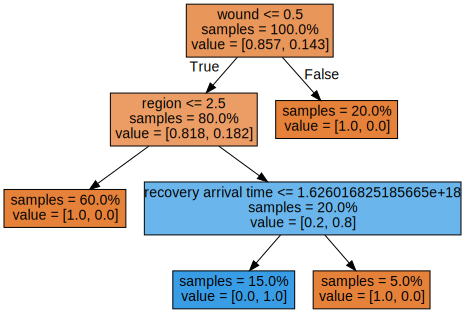

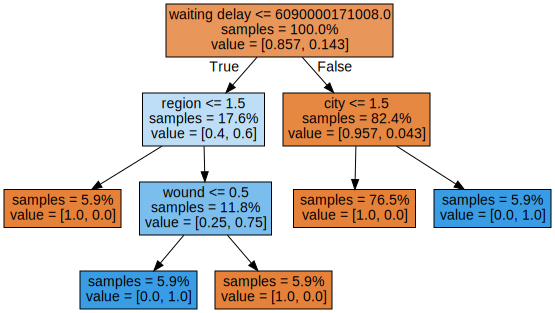

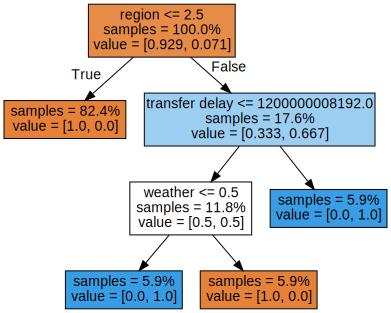

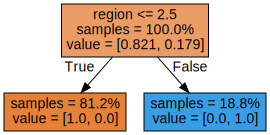

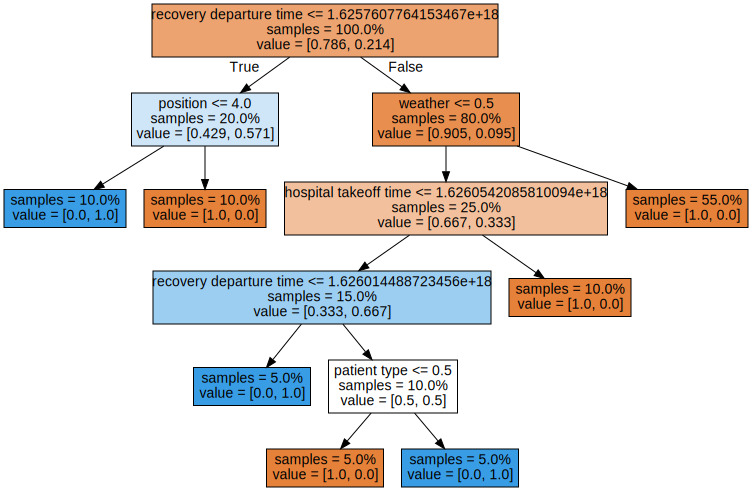

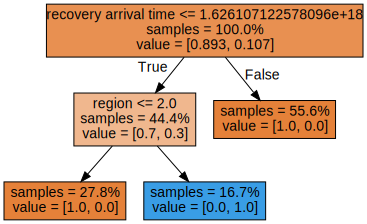

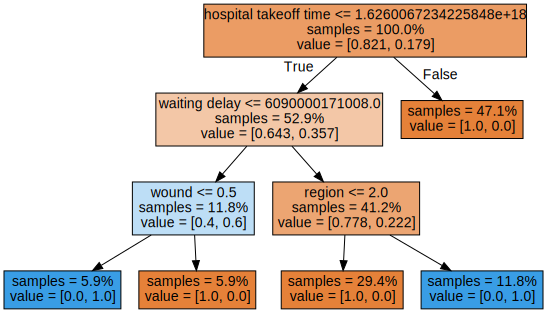

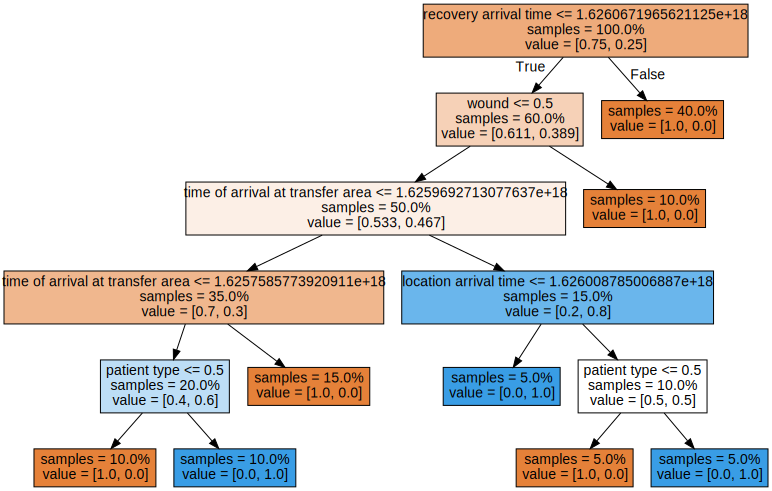

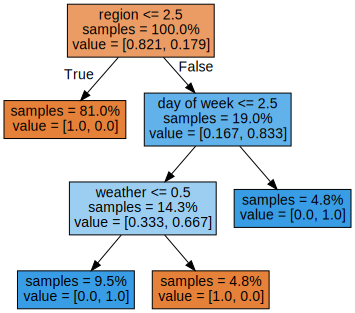

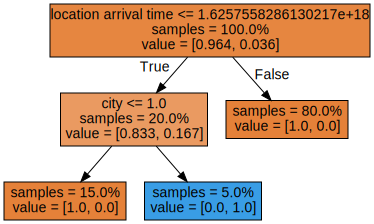

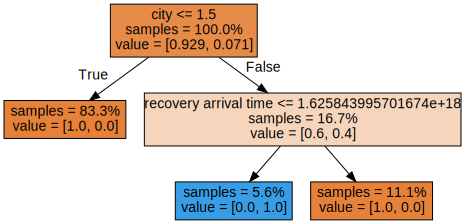

In [36]:
print("Forest population: ", len(rf.estimators_))

# Export all the decision trees from the forest
for tree in rf.estimators_[:11]:
  dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=5, impurity=False, proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

In [53]:
n_estimators = randint(50, 500)
max_depth= randint(1, 20)

param_dist = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Create a ranom forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=20, cv=15)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=15.
  warnings.warn(


RandomizedSearchCV(cv=15, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79bd51a01120>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x79bd51971720>})

In [54]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best parameters
print('Best hyperparameters: ', rand_search.best_params_)

Best hyperparameters:  {'max_depth': 6, 'n_estimators': 369}


Accuracy:  0.9166666666666666
Precision:  0.0
Recall: 0.0
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

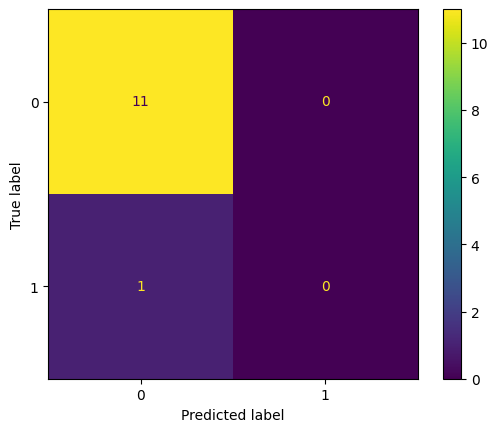

In [55]:
# Generate predictions wit the best model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

따라서 최적화된 모델을 기준으로 각각의 요소들이 결과 y의 값에 얼마나 큰 영향을 주는지 검색할 수 있습니다.

<Axes: >

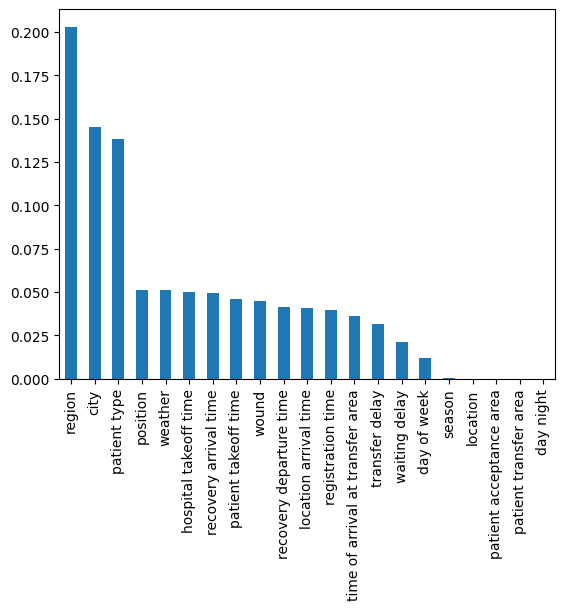

In [40]:
# Create a series containing feature importances from the model and their names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

하지만 혼돈 행렬을 통해 보셨다시피, 현재 모델을 기준으로 예측 성능이 많이 부족합니다.
이의 가장 큰 이유가 데이터 부족도 있겠지만, 우선 데이터 비율은 한 y 값이 과하게 묘사 됐으며, 그에 비해 다른 한 값은 너무 적게 나타난다.
이 현상을 unbalanced data로 표현하며 소수와 다수의 비율이 너무 뚜렷한 게 문제입니다.

앞으로 이 편향된 데이터셋을 가지고 더 균형 잡혀 보이도록 학습하는 방법을 알아보겠습니다.

In [41]:
from statistics import mean
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Accuracy:  0.75
Precision:  0.25
Recall: 1.0
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.25      1.00      0.40         1

    accuracy                           0.75        12
   macro avg       0.62      0.86      0.62        12
weighted avg       0.94      0.75      0.81        12



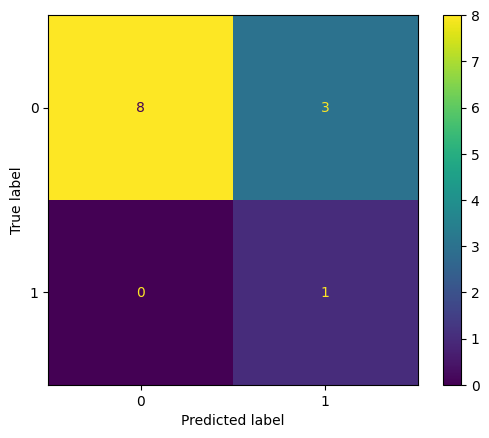

In [47]:
# Build BRF model
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)

# Create Strtified K-Fold cross validation
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate BRF model
'''scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
'''
BRFC.fit(X_train, y_train)

# BRFC prediction result
y_pred = BRFC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

In [43]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to oversample the minority clss
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)

# Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)


# Randomly split dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))


ValueError: ignored